## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [120]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
plt.style.use("seaborn")
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [121]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)
records.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [122]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [123]:
#records.hist(figsize=(20,20));


list_of_correlations= records.corr(method='pearson')
plt.figure(figsize=(11,7))
sns.heatmap(list_of_correlations,linewidths=0.005,linecolor='k')
plt.title('Correlation Heatmap')
plt.show()



## Normalize data

In [124]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

## Compare hists between classes

In [125]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
#records0.hist(figsize=(20,20));

In [126]:
#records1.hist(figsize=(20,20));

print("Differences between fraud and non-fraud:")
for i in records0.keys():
    print("Differences in",i)
    print("Median:", records0[i].median()-records1[i].median())
    print("Mean:", records0[i].mean()-records1[i].mean())
    print("Std:", records0[i].std()-records1[i].std())
    
    print()

In [127]:
lrg_for_RFE = LogisticRegression()
selector = RFE(lrg_for_RFE, n_features_to_select=10, step=1)
selector.fit(normalized_records, targets)
print(selector.support_)
print(selector.ranking_)

df = pd.DataFrame(zip(normalized_records.columns, selector.support_), columns=['Label','Support'])
df[df.Support == True].Label.to_numpy()

[False False False False  True False False False  True  True  True False
 False  True  True False  True False False False False  True  True False
 False False False  True False False]
[10  5 20 18  1  4  8  7  1  1  1 15 12  1  1 11  1 17 19 13  2  1  1 14
  3 16 21  1  9  6]


array(['V4', 'V8', 'V9', 'V10', 'V13', 'V14', 'V16', 'V21', 'V22', 'V27'],
      dtype=object)

In [129]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']
top10_cormat = ['V11','V4','V2','V21','V19','V20','V8','V27','V28']
top10_RFE = ['V4', 'V8', 'V9', 'V10', 'V13', 'V14', 'V16', 'V21', 'V22', 'V27']

X = normalized_records[top10].to_numpy()
X_cormat = normalized_records[top10_cormat].to_numpy()
X_RFE = normalized_records[top10_RFE].to_numpy()
y = targets.to_numpy()

In [132]:

oversample = imblearn.over_sampling.SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)
X_smote_cormat, y_smote = oversample.fit_resample(X_cormat, y)
X_smote_RFE, y_smote = oversample.fit_resample(X_RFE, y)

lrg3 = LogisticRegression()
lrg3_cormat = LogisticRegression()
lrg3_RFE = LogisticRegression()

X_train3, X_validation3, y_train3, y_validation3 = train_test_split(X_smote, y_smote, test_size=0.60, random_state=42)
lrg3.fit(X_train3, y_train3)

X_train3_cormat, X_validation3_cormat, y_train3_cormat, y_validation3_cormat = train_test_split(X_smote_cormat, y_smote, test_size=0.60, random_state=42)
lrg3_cormat.fit(X_train3_cormat, y_train3_cormat)

X_train3_RFE, X_validation3_RFE, y_train3_RFE, y_validation3_RFE = train_test_split(X_smote_RFE, y_smote, test_size=0.60, random_state=42)
lrg3_RFE.fit(X_train3_RFE, y_train3_RFE)

LogisticRegression()

In [133]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)

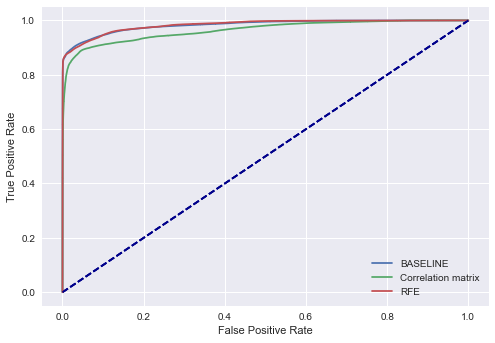

In [134]:
create_roc_curve(lrg3.predict_proba(X_validation3)[:,1], y_validation3, label="BASELINE")
create_roc_curve(lrg3_cormat.predict_proba(X_validation3_cormat)[:,1], y_validation3_cormat, label="Correlation matrix")
create_roc_curve(lrg3_RFE.predict_proba(X_validation3_RFE)[:,1], y_validation3_RFE, label="RFE")


[0.936646505993017, 0.9206793940602791, 0.9332492833016895]
(341178,)


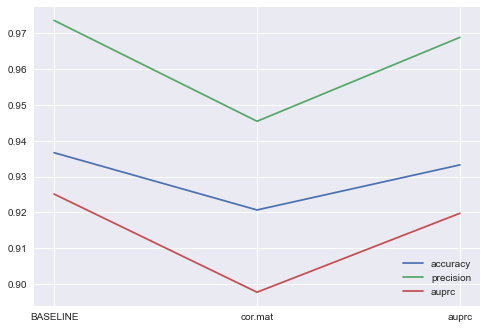

In [141]:
smot = lrg3.predict(X_validation3)
cormatauprc = lrg3_cormat.predict(X_validation3_cormat)
rfeauprc = lrg3_RFE.predict(X_validation3_RFE)

accur = [roc_auc_score(y_validation3, smot), roc_auc_score(y_validation3_cormat, cormatauprc), roc_auc_score(y_validation3_RFE, rfeauprc)]
auprc = [average_precision_score(y_validation3, smot), average_precision_score(y_validation3_cormat, cormatauprc), average_precision_score(y_validation3_RFE, rfeauprc)]
precision = [precision_score(y_validation3, smot), precision_score(y_validation3_cormat, cormatauprc), precision_score(y_validation3_RFE, rfeauprc)]

print (accur)

labels = ['BASELINE', 'cor.mat','auprc']
plt.plot(labels, accur, label="accuracy")
plt.plot(labels, precision, label="precision")
plt.plot(labels, auprc, label="auprc")

plt.legend(loc='lower right')

print(smot.shape)


In [137]:
cormatauprc


array([1, 1, 0, ..., 0, 1, 0], dtype=int64)